In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from category_encoders.target_encoder import TargetEncoder

from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import mutual_info_regression

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
!pip install category_encoders

In [7]:
df = pd.read_csv(r"C:\Users\khami\Desktop\ML2 regression\data\raw\housing.csv")

In [13]:
df = df.drop(columns=[
    "id",
    "url",
    "region_url",
    "image_url",
    "description"
])
df.head()

,region,price,type,sqfeet,beds,baths,cats_allowed,dogs_allowed,smoking_allowed,wheelchair_access,electric_vehicle_charge,comes_furnished,laundry_options,parking_options,lat,long,state
0,reno / tahoe,1148,apartment,1078,3,2.0,1,1,0,0,0,0,w/d in unit,carport,39.5483,-119.796,ca
1,reno / tahoe,1200,condo,1001,2,2.0,0,0,0,0,0,0,w/d hookups,carport,39.5026,-119.789,ca
2,reno / tahoe,1813,apartment,1683,2,2.0,1,1,1,0,0,0,w/d in unit,attached garage,39.6269,-119.708,ca
3,reno / tahoe,1095,apartment,708,1,1.0,1,1,1,0,0,0,w/d in unit,carport,39.4477,-119.771,ca
4,reno / tahoe,289,apartment,250,0,1.0,1,1,1,1,0,1,laundry on site,NaN,39.5357,-119.805,ca


In [61]:
for i in ['laundry_options', 'parking_options', 'state', 'type', 'region']:
    print(df[i].value_counts(normalize=True))
    print('')
    print('')

laundry_options
w/d in unit           0.341187
unknown               0.207100
w/d hookups           0.198146
laundry on site       0.151587
laundry in bldg       0.092674
no laundry on site    0.009305
Name: proportion, dtype: float64


parking_options
unknown               0.367189
off-street parking    0.333769
attached garage       0.103312
carport               0.101167
detached garage       0.044180
street parking        0.041677
no parking            0.008331
valet parking         0.000375
Name: proportion, dtype: float64


state
ca    0.086506
fl    0.083984
tx    0.081200
nc    0.048677
mi    0.038209
ga    0.036429
oh    0.033670
tn    0.030461
co    0.029711
va    0.029086
sc    0.026286
ny    0.026151
pa    0.026052
il    0.025445
al    0.021726
or    0.021361
ks    0.020725
ia    0.019741
md    0.019682
mn    0.019671
la    0.019339
wa    0.018674
az    0.017580
wi    0.017450
in    0.016947
ok    0.015305
nj    0.014818
ky    0.014337
ut    0.013621
ms    0.013182
ma    0.

PRICE
99% = 3395
99.9% = 7365
Max = 2.7 billion (garbage)
SQFEET
99% = 2405
99.9% = 4200
Max = 8.3 million (garbage)
Real data ends around:
price ≈ 7,000
sqfeet ≈ 4,000

In [15]:
df = df[df["price"].between(1, df["price"].quantile(0.999))]
df = df[df["sqfeet"].between(100, df["sqfeet"].quantile(0.999))]
df = df[df["beds"].between(0, 10)]
df = df[df["baths"].between(0, 6)]
df = df[df["lat"].between(20, 50)]
df = df[df["long"].between(-130, -60)]

df.shape

(375823, 17)

In [22]:
cat_cols = df.select_dtypes(include=["object", "category"]).columns
df[cat_cols] = df[cat_cols].fillna("unknown")
df.isna().sum()

region                     0
price                      0
type                       0
sqfeet                     0
beds                       0
baths                      0
cats_allowed               0
dogs_allowed               0
smoking_allowed            0
wheelchair_access          0
electric_vehicle_charge    0
comes_furnished            0
laundry_options            0
parking_options            0
lat                        0
long                       0
state                      0
dtype: int64

In [24]:
df["price_log"] = np.log1p(df["price"])
df["sqfeet_log"] = np.log1p(df["sqfeet"])

df[["price", "price_log", "sqfeet", "sqfeet_log"]].head()

,price,price_log,sqfeet,sqfeet_log
0,1148,7.046647,1078,6.983790
1,1200,7.090910,1001,6.909753
2,1813,7.503290,1683,7.428927
3,1095,6.999422,708,6.563856
4,289,5.669881,250,5.525453


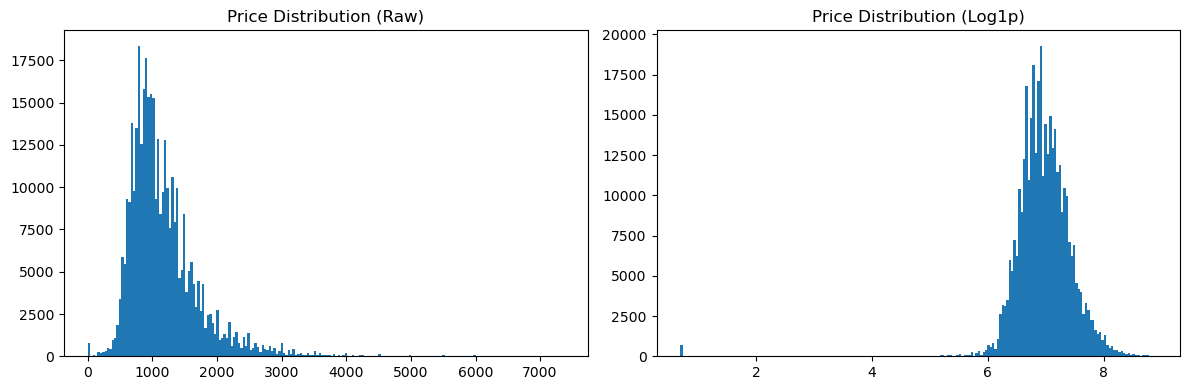

In [26]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.hist(df["price"], bins=200)
plt.title("Price Distribution (Raw)")

plt.subplot(1,2,2)
plt.hist(df["price_log"], bins=200)
plt.title("Price Distribution (Log1p)")
plt.tight_layout()
plt.show()

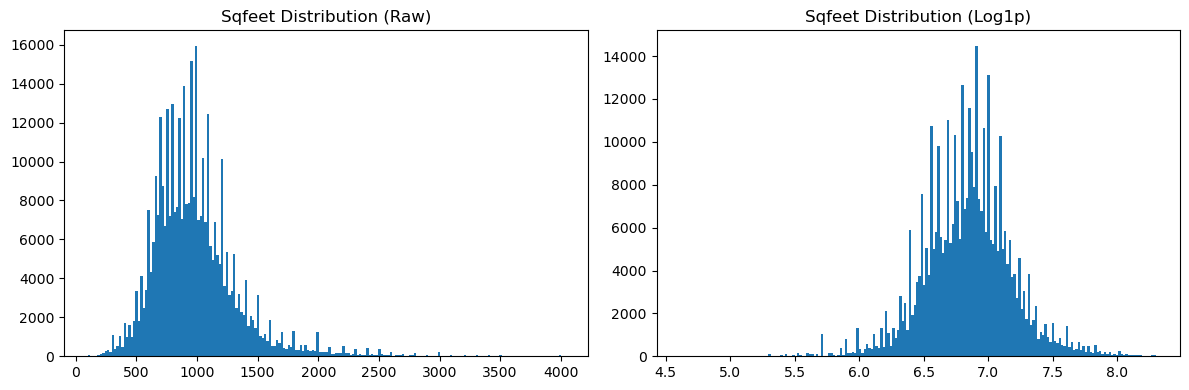

In [30]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.hist(df["sqfeet"], bins=200)
plt.title("Sqfeet Distribution (Raw)")

plt.subplot(1,2,2)
plt.hist(df["sqfeet_log"], bins=200)
plt.title("Sqfeet Distribution (Log1p)")
plt.tight_layout()
plt.show()

Raw: The data is "bunched up" near the low end with outliers stretching the scale.

Log1p: The transformation has successfully centered the data and made the distribution more symmetrical.

I have 375k+ rows → plenty of data

Models I will use (RF, GBM, XGBoost) benefit from more training data

10% validation + 10% test is more than enough for stable evaluation

60/20/20 or 70/15/15 would waste training potential with no benefit

In [34]:
X = df.drop(columns=["price", "price_log"])
y = df["price_log"]

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.20, random_state=42
)

X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42
)

X_train.shape, X_valid.shape, X_test.shape

((300658, 17), (37582, 17), (37583, 17))

Low‑cardinality features (type, state)
These have only a few unique values. One‑Hot Encoding is ideal because it creates clean binary columns without causing dimensionality explosion. EDA confirmed these columns are stable and well‑distributed.

High‑cardinality feature (region)
This column contains hundreds of unique regions, and OHE would create too many sparse columns, harming model performance. During EDA we saw that region strongly correlates with price patterns, so Target Encoding is appropriate because it compresses many categories into a single meaningful numeric feature based on average target values.

In [63]:
top_regions = df["region"].value_counts().nlargest(30).index
df["region_grouped"] = df["region"].where(df["region"].isin(top_regions), "other")

In [65]:
ohe_cols = ["type", "state", "laundry_options", "parking_options"]
target_enc_cols = ["region_grouped"]

In [67]:
ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
target_enc = TargetEncoder()

In [69]:
numeric_cols = X_train.select_dtypes(include=["int64", "float64"]).columns

preprocessor = ColumnTransformer(
    transformers=[
        ("ohe", ohe, ohe_cols),
        ("target", target_enc, target_enc_cols),
        ("num", "passthrough", numeric_cols)
    ]
)

In [71]:
for X in [X_train, X_valid, X_test]:
    X["region_grouped"] = X["region"].where(X["region"].isin(top_regions), "other")

X_train_transformed = preprocessor.fit_transform(X_train, y_train)
X_valid_transformed = preprocessor.transform(X_valid)
X_test_transformed = preprocessor.transform(X_test)

X_train_transformed.shape, X_valid_transformed.shape, X_test_transformed.shape

((300658, 89), (37582, 89), (37583, 89))

In [73]:
df.to_csv(r"C:\Users\khami\Desktop\ML2 regression\data\processed\df_cleaned.csv", index=False)

In [75]:
X_train.to_csv(r"C:\Users\khami\Desktop\ML2 regression\data\processed\X_train_raw.csv", index=False)
X_valid.to_csv(r"C:\Users\khami\Desktop\ML2 regression\data\processed\X_valid_raw.csv", index=False)
X_test.to_csv(r"C:\Users\khami\Desktop\ML2 regression\data\processed\X_test_raw.csv", index=False)

y_train.to_csv(r"C:\Users\khami\Desktop\ML2 regression\data\processed\y_train.csv", index=False)
y_valid.to_csv(r"C:\Users\khami\Desktop\ML2 regression\data\processed\y_valid.csv", index=False)
y_test.to_csv(r"C:\Users\khami\Desktop\ML2 regression\data\processed\y_test.csv", index=False)

In [77]:
import pickle

with open(r"C:\Users\khami\Desktop\ML2 regression\artifacts\preprocessing\preprocessor.pkl", "wb") as f:
    pickle.dump(preprocessor, f)

In [79]:
import numpy as np

np.save(r"C:\Users\khami\Desktop\ML2 regression\artifacts\preprocessing\X_train_transformed.npy", X_train_transformed)
np.save(r"C:\Users\khami\Desktop\ML2 regression\artifacts\preprocessing\X_valid_transformed.npy", X_valid_transformed)
np.save(r"C:\Users\khami\Desktop\ML2 regression\artifacts\preprocessing\X_test_transformed.npy", X_test_transformed)

1. Data Cleaning
Handled missing values in categorical and numerical features

Removed extreme outliers using quantile-based filtering

Applied log1p transformation to skewed variables (price, sqfeet)

2. Train/Valid/Test Split
Split the cleaned dataset into 80/10/10 partitions

Ensured no data leakage by splitting before any encoding or scaling

3. Categorical Feature Engineering
Identified high‑cardinality column region (401 categories)

Grouped top 30 most frequent regions and labeled the rest as "other"

Prepared final categorical groups for encoding:

One‑Hot Encoding: type, state, laundry_options, parking_options

Target Encoding: region_grouped

4. Preprocessing Pipeline
Built a unified ColumnTransformer containing:

OneHotEncoder for low/medium‑cardinality features

TargetEncoder for grouped high‑cardinality region

Passthrough for all numerical columns

Ensured consistent transformations across train, validation, and test sets

5. Data Transformation
Fit the preprocessing pipeline on the training set

Transformed validation and test sets

Final feature matrices produced: 89 features

6. Saving Artifacts
Saved cleaned dataset, raw splits, preprocessing pipeline, and transformed matrices into the project’s artifact folders for use in Notebook 3.